In [1]:
from qiskit import QuantumCircuit
import sys

sys.path.append('..')
from cutter import *
from cutqc_test_function import *

2023-12-13 16:56:45,898	INFO util.py:159 -- Outdated packages:
  ipywidgets==7.7.5 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


/home/jiaxinghui/anaconda3/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


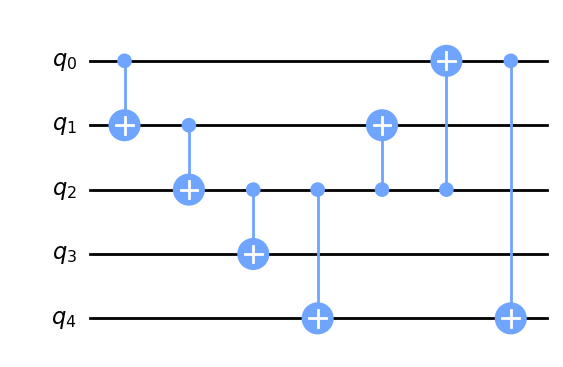

In [2]:
qc = QuantumCircuit(5)
for i in range(3):
    qc.cx(i, i + 1)
qc.cx(2, 4)
qc.cx(2, 1)
qc.cx(2, 0)
qc.cx(0, 4)
qc.draw('mpl')

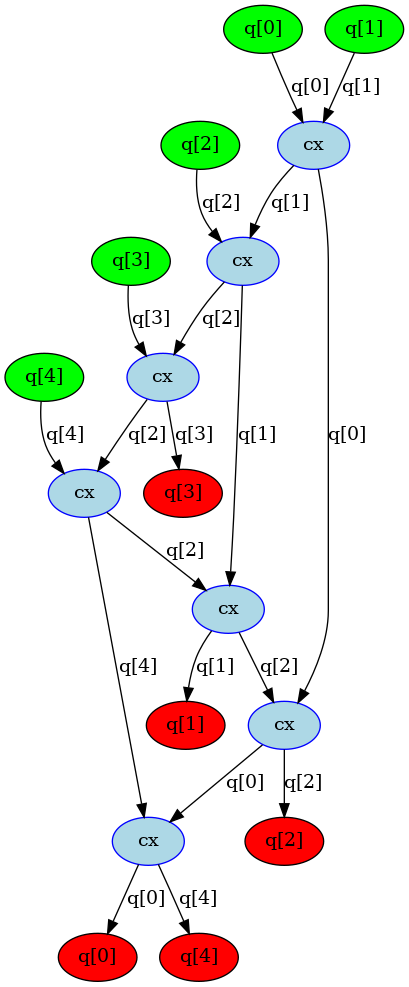

In [3]:
circuit_to_dag(qc).draw('mpl')

/home/jiaxinghui/anaconda3/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


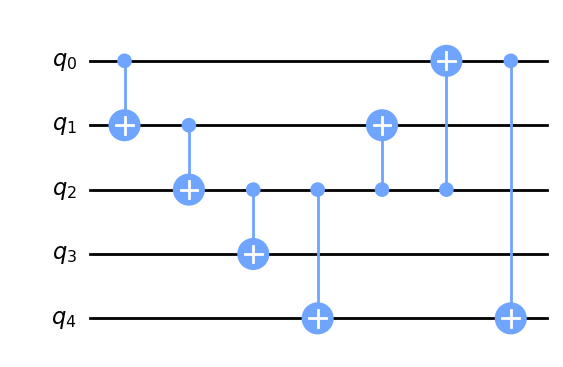

In [4]:
qc.draw('mpl')

In [5]:
# mip_subcircuits = [["q[0]0 q[1]0", "q[1]1 q[2]0"], ["q[2]1 q[3]0", "q[3]1 q[4]0"]]
mip_subcircuits = [["q[0]0 q[1]0", "q[1]1 q[2]0"], ["q[2]1 q[3]0", "q[2]2 q[4]0", "q[2]3 q[1]2", "q[2]4 q[0]1", "q[0]2 q[4]1"]]
cut_solution = cut_parser_test(qc, mip_subcircuits, 3)
subcircuits = cut_solution['subcircuits']
complete_path_map = cut_solution['complete_path_map']
counter = cut_solution['counter']
print(cut_solution['subcircuits'][0])
print(cut_solution['subcircuits'][1])
print(cut_solution['complete_path_map'])
print(cut_solution['counter'])
#################################
# 以上为切割

               
q_0: ──■───────
     ┌─┴─┐     
q_1: ┤ X ├──■──
     └───┘┌─┴─┐
q_2: ─────┤ X ├
          └───┘
                    ┌───┐     
q_0: ───────────────┤ X ├──■──
               ┌───┐└─┬─┘  │  
q_1: ──────────┤ X ├──┼────┼──
               └─┬─┘  │    │  
q_2: ──■────■────■────■────┼──
     ┌─┴─┐  │              │  
q_3: ┤ X ├──┼──────────────┼──
     └───┘┌─┴─┐          ┌─┴─┐
q_4: ─────┤ X ├──────────┤ X ├
          └───┘          └───┘
{Qubit(QuantumRegister(5, 'q'), 0): [{'subcircuit_idx': 0, 'subcircuit_qubit': Qubit(QuantumRegister(3, 'q'), 0)}, {'subcircuit_idx': 1, 'subcircuit_qubit': Qubit(QuantumRegister(5, 'q'), 0)}], Qubit(QuantumRegister(5, 'q'), 1): [{'subcircuit_idx': 0, 'subcircuit_qubit': Qubit(QuantumRegister(3, 'q'), 1)}, {'subcircuit_idx': 1, 'subcircuit_qubit': Qubit(QuantumRegister(5, 'q'), 1)}], Qubit(QuantumRegister(5, 'q'), 2): [{'subcircuit_idx': 0, 'subcircuit_qubit': Qubit(QuantumRegister(3, 'q'), 2)}, {'subcircuit_idx': 1, 'subcircuit_qubit': Qubi

In [6]:
######################################
# 运行前
compute_graph = generate_compute_graph(counter, subcircuits, complete_path_map)
subcircuit_entries, subcircuit_instances = generate_subcircuit_entries(compute_graph)

In [9]:
# 运行
instance_init_meas_ids = {}
run_circuit_res = {}
for subcircuit_idx in subcircuit_instances:
    jobs = subcircuit_instances[subcircuit_idx]
    instance_init_meas_ids[subcircuit_idx] = {jobs[i]: i for i in range(len(jobs))}
    subcircuit = subcircuits[subcircuit_idx]
    uniform_p = 1 / 2**subcircuit.num_qubits
    num_shots = None
    for instance_init_meas in jobs:
        if "Z" in instance_init_meas[1]:
            continue
        subcircuit_instance = modify_subcircuit_instance(
            subcircuit=subcircuit,
            init=instance_init_meas[0],
            meas=instance_init_meas[1],
        )
        subcircuit_inst_prob = evaluate_circ(
            circuit=subcircuit_instance, backend="statevector_simulator"
        )
        mutated_meas = mutate_measurement_basis(meas=instance_init_meas[1])
        for meas in mutated_meas:
            measured_prob = measure_prob(
                unmeasured_prob=subcircuit_inst_prob, meas=meas
            )
            instance_init_meas_id = instance_init_meas_ids[subcircuit_idx][
                (instance_init_meas[0], meas)
            ]
            run_circuit_res[(subcircuit_idx, instance_init_meas_id)] = measured_prob

In [10]:
######################################
# 重建前
attribute_shots_res = {}
entry_init_meas_ids = {}
for subcircuit_idx in subcircuit_entries:
    entry_init_meas_ids[subcircuit_idx] = {}
    i = 0
    for key in subcircuit_entries[subcircuit_idx]:
        entry_init_meas_ids[subcircuit_idx][key] = i
        i += 1
for subcircuit_idx in subcircuit_entries:
    attribute_shots_jobs = list(subcircuit_entries[subcircuit_idx].keys())
    subcircuit = subcircuits[subcircuit_idx]
    attribute_shots_jobs = {
        key: subcircuit_entries[subcircuit_idx][key] for key in attribute_shots_jobs
    }
    for subcircuit_entry_init_meas in attribute_shots_jobs:
        subcircuit_entry_term = attribute_shots_jobs[subcircuit_entry_init_meas]
        subcircuit_entry_prob = None
        for term in subcircuit_entry_term:
            coefficient, subcircuit_instance_init_meas = term
            subcircuit_instance_init_meas_id = instance_init_meas_ids[
                subcircuit_idx
            ][subcircuit_instance_init_meas]
            if subcircuit_entry_prob is None:
                subcircuit_entry_prob = coefficient * run_circuit_res[(subcircuit_idx, subcircuit_instance_init_meas_id)]
            else:
                subcircuit_entry_prob += coefficient * run_circuit_res[(subcircuit_idx, subcircuit_instance_init_meas_id)]
        entry_init_meas_id = entry_init_meas_ids[subcircuit_idx][subcircuit_entry_init_meas]
        attribute_shots_res[(subcircuit_idx, entry_init_meas_id)] = subcircuit_entry_prob
print(attribute_shots_res)
# subcircuit_capacities = {
#     subcircuit_idx: compute_graph.nodes[subcircuit_idx]["effective"]
#     for subcircuit_idx in compute_graph.nodes
# }
# subcircuit_active_qubits = distribute_load(
#         capacities=subcircuit_capacities
# )
# qubit_states = []

# for subcircuit_idx in subcircuit_active_qubits:
#     num_zoomed = 0
#     num_active = subcircuit_active_qubits[subcircuit_idx]
#     num_merged = (
#         compute_graph.nodes[subcircuit_idx]["effective"]
#         - num_zoomed
#         - num_active
#     )
#     qubit_states.append(["active" for _ in range(num_active)] + ["merged" for _ in range(num_merged)])

# merged_subcircuit_entry_probs = {}
# for subcircuit_idx in entry_init_meas_ids:
#     jobs=list(entry_init_meas_ids[subcircuit_idx].keys())
#     merged_subcircuit_entry_probs[subcircuit_idx] = {}
#     for subcircuit_entry_init_meas in jobs:
#         subcircuit_entry_id = entry_init_meas_ids[subcircuit_idx][
#             subcircuit_entry_init_meas
#         ]
#         unmerged_prob_vector = attribute_shots_res[(subcircuit_idx, subcircuit_entry_id)]
#         merged_subcircuit_entry_probs[subcircuit_idx][
#             subcircuit_entry_init_meas
#         ] = merge_prob_vector(
#             unmerged_prob_vector=unmerged_prob_vector,
#             qubit_states=qubit_states[subcircuit_idx],
#         )
# for prob in merged_subcircuit_entry_probs:
#     print(len(merged_subcircuit_entry_probs[prob]))

{(0, 0): array([1.]), (0, 1): array([2.22044605e-16]), (0, 2): array([2.22044605e-16]), (0, 3): array([1.]), (0, 4): array([2.22044605e-16]), (0, 5): array([0.]), (0, 6): array([0.]), (0, 7): array([2.22044605e-16]), (0, 8): array([2.22044605e-16]), (0, 9): array([0.]), (0, 10): array([0.]), (0, 11): array([2.22044605e-16]), (0, 12): array([1.]), (0, 13): array([2.22044605e-16]), (0, 14): array([2.22044605e-16]), (0, 15): array([1.]), (0, 16): array([2.22044605e-16]), (0, 17): array([0.]), (0, 18): array([0.]), (0, 19): array([2.22044605e-16]), (0, 20): array([0.]), (0, 21): array([-5.55111512e-17]), (0, 22): array([-5.55111512e-17]), (0, 23): array([0.]), (0, 24): array([0.]), (0, 25): array([-5.55111512e-17]), (0, 26): array([-5.55111512e-17]), (0, 27): array([0.]), (0, 28): array([2.22044605e-16]), (0, 29): array([0.]), (0, 30): array([0.]), (0, 31): array([2.22044605e-16]), (0, 32): array([2.22044605e-16]), (0, 33): array([0.]), (0, 34): array([0.]), (0, 35): array([2.22044605e-16]

In [12]:
##################################################
# 重建
print(attribute_shots_res.__len__())
state = None
for i in range(64):
    if i == 0:
        state = np.kron(attribute_shots_res[(0, i)], attribute_shots_res[(1, i)])
    else:
        state += np.kron(attribute_shots_res[(0, i)], attribute_shots_res[(1, i)])
print(0.5 * state)

128
